In [60]:
import torch
import argparse
import glob
import math
import random
import numpy as np
import pandas as pd
import tqdm as tqdm
from scipy.special import softmax
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from captum.attr import visualization

from transformers import AutoTokenizer

import datasets
from datasets import load_dataset, load_metric 
from datasets import list_datasets, list_metrics

from BERT_explainability.modules.BERT.BertForSequenceClassification import BertForSequenceClassification

In [61]:
# load model   
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2").to("cuda")
model.eval()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

In [3]:
dataset = "glue" # select a dataset
task = "sst2" # select a task
dataset = load_dataset(dataset, task) # load dataset

In [63]:
special_tokens = {"[CLS]", "[SEP]"}
special_idxs = {101,102}    
mask = "[PAD]"
mask_id = 0   

In [64]:
def preprocess_sample(text):
    tokenized_input  = tokenizer(text, add_special_tokens=True, truncation=True)
    input_ids = tokenized_input['input_ids']
    text_ids = (torch.tensor([input_ids])).to("cuda")
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0])
    
    # mask special tokens
    att_mask = tokenized_input['attention_mask']
    spe_idxs = [x for x, y in list(enumerate(input_ids)) if y in special_idxs]
    att_mask = [0 if index in spe_idxs else 1 for index, item in enumerate(att_mask)]
    att_mask = [0 if index in spe_idxs else 1 for index, item in enumerate(att_mask)]
    att_mask = (torch.tensor([att_mask])).to("cuda")
    
    return text_ids, att_mask, text_words

In [65]:
def predict(model, text_ids, target, att_mask=None, seg_ids=None):
    out = model(text_ids, attention_mask=att_mask, token_type_ids=seg_ids)
    prob = out[0]
    pred_class = torch.argmax(prob, axis=1).cpu().detach().numpy()
    pred_class_prob = softmax(prob.cpu().detach().numpy(), axis=1)
    return pred_class[0], pred_class_prob[:, target][0]

In [66]:
def truncate_words(sorted_idx, text_words, text_ids, replaced_num, seg_ids=None):
    to_be_replaced_idx = []
    i= 0
    while len(to_be_replaced_idx) < replaced_num and i!=len(text_words)-1:
        current_idx = sorted_idx[i]
        if text_words[current_idx] not in special_tokens:
            to_be_replaced_idx.append(current_idx)
        i += 1
    remaining_idx = sorted(list(set(sorted_idx) - set(to_be_replaced_idx)))
    truncated_text_ids = text_ids[0, np.array(remaining_idx)]
    if seg_ids is not None:
        seg_ids = seg_ids[0, np.array(remaining_idx)]
    truncated_text_words = np.array(text_words)[remaining_idx]
    return truncated_text_ids.unsqueeze(0), truncated_text_words, seg_ids

In [67]:
def replace_words(sorted_idx, text_words, text_ids, replaced_num, mask, mask_id):
    to_be_replaced_idx = []
    i= 0
    while len(to_be_replaced_idx) < replaced_num and i!=len(text_words)-1:
        current_idx = sorted_idx[i]
        if text_words[current_idx] not in special_tokens:
            to_be_replaced_idx.append(current_idx)
        i += 1
    replaced_text_ids = text_ids.clone()
    replaced_text_ids[0, to_be_replaced_idx] = mask_id
    replaced_text_words = np.copy(text_words)
    replaced_text_words[to_be_replaced_idx] = mask
    return replaced_text_ids, replaced_text_words

In [68]:
# compute rollout between attention layers
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
        
    return joint_attention

In [69]:
class Generator:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    
    def generate_TransCAM(self, input_ids, attention_mask,
                          index=None, start_layer=0):

        result = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        output = result[0]
        hs = result[1]

        kwargs = {"alpha": 1}

        blocks = self.model.bert.encoder.layer

        for blk_id in range(len(blocks)):
            hs[blk_id].retain_grad()

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = {}
        
        for blk_id in range(len(blocks)):
            hs_grads = hs[blk_id].grad
            
            att = blocks[blk_id].attention.self.get_attn().squeeze(0)
            att = att.mean(dim=0)
            att = att.mean(dim=0)
            
            cat = (hs_grads * hs[blk_id]).sum(dim=-1).squeeze(0)
            cat = cat * att
            
            cams[blk_id] = cat
            
        trans_expln = sum(cams.values())

        return trans_expln

    def generate_LRP(self, input_ids, attention_mask,
                     index=None, start_layer=11):
        
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = []
        blocks = self.model.bert.encoder.layer
        for blk in blocks:
            grad = blk.attention.self.get_attn_gradients()
            cam = blk.attention.self.get_attn_cam()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
            cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            cams.append(cam.unsqueeze(0))
        rollout = compute_rollout_attention(cams, start_layer=start_layer)
        rollout[:, 0, 0] = 0
        return rollout[:, 0]

    def generate_LRP_last_layer(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn_cam()[0]
        cam = cam.clamp(min=0).mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_full_lrp(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        cam = self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)
        cam = cam.sum(dim=2)
        cam[:, 0] = 0
        return cam

    def generate_attn_last_layer(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()[0]
        cam = cam.mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_rollout(self, input_ids, attention_mask, start_layer=0, index=None):
        self.model.zero_grad()
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        blocks = self.model.bert.encoder.layer
        all_layer_attentions = []
        for blk in blocks:
            attn_heads = blk.attention.self.get_attn()
            avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
            all_layer_attentions.append(avg_heads)
        rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
        rollout[:, 0, 0] = 0
        return rollout[:, 0]

    def generate_attn_gradcam(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()
        grad = self.model.bert.encoder.layer[-1].attention.self.get_attn_gradients()

        cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0).unsqueeze(0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam[:, 0, 0] = 0
        
        return cam[:, 0]

In [70]:
def generate_explns(explanations, input_ids, attention_mask, start_layer=0, true_class = 1, is_true = True):
    
    if is_true:
        # TransCAM
        TransCAM_expln = explanations.generate_TransCAM(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)
        # LRP
        LRP_expln = explanations.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)[0]
        # PartialLRP
        PartialLRP_expln = explanations.generate_LRP_last_layer(input_ids=input_ids, 
                                                     index=true_class, attention_mask=attention_mask)[0]
        # FullLRP
        # FullLRP_expln = explanations.generate_full_lrp(input_ids=input_ids, attention_mask=attention_mask, 
        #                                           index=true_class)[0]
        # Att
        Att_expln = explanations.generate_attn_last_layer(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class)[0]
        # Rollout
        Rollout_expln = explanations.generate_rollout(input_ids=input_ids, attention_mask=attention_mask,      
                                                    index=true_class, start_layer=0)[0]
        # Att_Gradcam
        # Att_Gradcam_expln = explanations.generate_attn_gradcam(input_ids=input_ids, attention_mask=attention_mask, 
        #                                            index=true_class)[0]    
        
    else:
        true_class = 1-true_class
        # TransCAM
        TransCAM_expln = explanations.generate_TransCAM(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)
        # LRP
        LRP_expln = explanations.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)[0]
        # PartialLRP
        PartialLRP_expln = explanations.generate_LRP_last_layer(input_ids=input_ids, 
                                                    index=true_class, attention_mask=attention_mask)[0]
        # FullLRP
        # FullLRP_expln = explanations.generate_full_lrp(input_ids=input_ids, attention_mask=attention_mask, 
        #                                            index=true_class)[0]
        # Att
        Att_expln = explanations.generate_attn_last_layer(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class)[0]
        # Rollout
        Rollout_expln = explanations.generate_rollout(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=0)[0]
        # Att_Gradcam
        # Att_Gradcam_expln = explanations.generate_attn_gradcam(input_ids=input_ids, attention_mask=attention_mask, 
        #                                            index=true_class)[0]
    
    # return TransCAM_expln, LRP_expln, PartialLRP_expln, FullLRP_expln, Att_expln, Rollout_expln, Att_Gradcam_expln
    return TransCAM_expln, Att_expln, PartialLRP_expln, Rollout_expln, LRP_expln

In [71]:
def cal_aopc(original_probs, degradation_probs):
    original_probs = np.array(original_probs)
    degradation_probs = np.array(degradation_probs)
    
    diffs = []
    for i in range(len(original_probs)):
        diffs_k = []
        for j in range(9):
            diff = original_probs[i] - degradation_probs[i][j]
            diffs_k.append(np.abs(diff))
        diffs.append(diffs_k)

    result = np.mean(diffs, axis=0)
    aopc = np.mean(result)
    
    return aopc

def cal_logodds(original_probs, degradation_probs):
    original_probs = np.array(original_probs)
    degradation_probs = np.array(degradation_probs)
    
    ratios = []
    for i in range(len(original_probs)):
        ratios_k = []
        for j in range(9):
            ratio = math.log(degradation_probs[i][j] / original_probs[i])
            ratios_k.append(ratio)
        ratios.append(ratios_k)

    result = np.mean(ratios, axis=0)
    logodds = np.mean(result)
    
    return logodds

def cal_kendaltau(attribution1, attribution2,):

    sorted_idx1 = np.argsort(-attribution1)
    sorted_idx2 = np.argsort(-attribution2)

    tau, p_value = stats.kendalltau(sorted_idx1, sorted_idx2)
    
    return tau

In [72]:
def test(model, explanations, test_data, degrade_step = 10, seg_ids=None):
    
    original_probs = []
    original_accs = [] 
    
    degradation_probs_TransCAM = []
    degradation_accs_TransCAM = []
    del_probs_TransCAM = []
    del_accs_TransCAM = []
    
    degradation_probs_Rawatt = []
    degradation_accs_Rawatt = []
    del_probs_Rawatt = []
    del_accs_Rawatt = []
    
    degradation_probs_PartialLRP = []
    degradation_accs_PartialLRP = []
    del_probs_PartialLRP = []
    del_accs_PartialLRP = []
    
    degradation_probs_Rollout = []
    degradation_accs_Rollout = []
    del_probs_Rollout = []
    del_accs_Rollout = []
    
    degradation_probs_LRP = []
    degradation_accs_LRP = []
    del_probs_LRP = []
    del_accs_LRP = []
    
    kendaltaus_TransCAM = []
    kendaltaus_Rawatt = []
    kendaltaus_PartialLRP = []
    kendaltaus_Rollout = []
    kendaltaus_LRP = []
    
    for i, test_instance in enumerate(test_data):
        
        text = test_instance['sentence']
        target = test_instance['label'] 

        text_ids, att_mask, text_words = preprocess_sample(text)
        
        # get truc words number
        total_len = len(text_words)
        if total_len< 10: 
            continue
        granularity = np.linspace(0, 1, degrade_step)
        trunc_words_num = [int(g) for g in np.round(granularity*total_len)]
        trunc_words_num = list(dict.fromkeys(trunc_words_num))
        
        original_class, original_prob = predict(model, text_ids, target)
        
        # get attributions
        attribution_TransCAM, attribution_Rawatt, attribution_PartialLRP, attribution_Rollout, attribution_LRP = \
        generate_explns(explanations, text_ids, att_mask, start_layer=0, true_class = target, is_true = True) 
        
        attribution_TransCAM_F, attribution_Rawatt_F, attribution_PartialLRP_F, attribution_Rollout_F, attribution_LRP_F = \
        generate_explns(explanations, text_ids, att_mask, start_layer=0, true_class = target, is_true = False) 
        
        # conver to cpu numpy
        attribution_TransCAM = attribution_TransCAM.cpu().detach().numpy()
        attribution_Rawatt = attribution_Rawatt.cpu().detach().numpy()
        attribution_PartialLRP = attribution_PartialLRP.cpu().detach().numpy()
        attribution_Rollout = attribution_Rollout.cpu().detach().numpy()
        attribution_LRP = attribution_LRP.cpu().detach().numpy()
        
        # conver to cpu numpy
        attribution_TransCAM_F = attribution_TransCAM_F.cpu().detach().numpy()
        attribution_Rawatt_F = attribution_Rawatt_F.cpu().detach().numpy()
        attribution_PartialLRP_F = attribution_PartialLRP_F.cpu().detach().numpy()
        attribution_Rollout_F = attribution_Rollout_F.cpu().detach().numpy()
        attribution_LRP_F = attribution_LRP_F.cpu().detach().numpy()
        
        # get sorted_idx
        sorted_idx_TransCAM = np.argsort(-attribution_TransCAM)
        sorted_idx_Rawatt = np.argsort(-attribution_Rawatt)
        sorted_idx_PartialLRP = np.argsort(-attribution_PartialLRP)
        sorted_idx_Rollout = np.argsort(-attribution_Rollout)
        sorted_idx_LRP = np.argsort(-attribution_LRP)
        
        instance_degradation_probs_TransCAM = []
        instance_degradation_accs_TransCAM = []
        instance_replace_probs_TransCAM = []
        instance_replace_accs_TransCAM = []
        
        instance_degradation_probs_Rawatt = []
        instance_degradation_accs_Rawatt = []
        instance_replace_probs_Rawatt = []
        instance_replace_accs_Rawatt = []
        
        instance_degradation_probs_PartialLRP = []
        instance_degradation_accs_PartialLRP = []
        instance_replace_probs_PartialLRP = []
        instance_replace_accs_PartialLRP = []
        
        instance_degradation_probs_Rollout = []
        instance_degradation_accs_Rollout = []
        instance_replace_probs_Rollout = []
        instance_replace_accs_Rollout = []
        
        instance_degradation_probs_LRP = []
        instance_degradation_accs_LRP = []
        instance_replace_probs_LRP = []
        instance_replace_accs_LRP = []

        for num in trunc_words_num[1:]: #exclude 0
            
            # TransCAM
            truncated_text_ids_TransCAM, _, _ = truncate_words(sorted_idx_TransCAM, text_words, text_ids, 
                                                                                        num, seg_ids=seg_ids)
            replaced_text_ids_TransCAM, _ = replace_words(sorted_idx_TransCAM, text_words, text_ids, num, mask, mask_id)
           
            trunc_class_TransCAM, trunc_prob_TransCAM = predict(model, truncated_text_ids_TransCAM, target, seg_ids=seg_ids)
            rep_class_TransCAM, rep_prob_TransCAM = predict(model, replaced_text_ids_TransCAM, target, seg_ids=seg_ids)

            instance_degradation_probs_TransCAM.append(trunc_prob_TransCAM)
            instance_degradation_accs_TransCAM.append(trunc_class_TransCAM==target)
            
            instance_replace_probs_TransCAM.append(rep_prob_TransCAM)
            instance_replace_accs_TransCAM.append(rep_class_TransCAM==target)
            
            # Rawatt
            truncated_text_ids_Rawatt, _, _ = truncate_words(sorted_idx_Rawatt, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_Rawatt, _ = replace_words(sorted_idx_Rawatt, text_words, text_ids, num, mask, mask_id)
            
            
            trunc_class_Rawatt, trunc_prob_Rawatt = predict(model, truncated_text_ids_Rawatt, target, seg_ids=seg_ids)
            rep_class_Rawatt, rep_prob_Rawatt = predict(model, replaced_text_ids_Rawatt, target, seg_ids=seg_ids)

            instance_degradation_probs_Rawatt.append(trunc_prob_Rawatt)
            instance_degradation_accs_Rawatt.append(trunc_class_Rawatt==target)
            
            instance_replace_probs_Rawatt.append(rep_prob_Rawatt)
            instance_replace_accs_Rawatt.append(rep_class_Rawatt==target)
            
            # PartialLRP
            truncated_text_ids_PartialLRP, _, _ = truncate_words(sorted_idx_PartialLRP, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_PartialLRP, _ = replace_words(sorted_idx_PartialLRP, text_words, text_ids, num, mask, mask_id)
            
            trunc_class_PartialLRP, trunc_prob_PartialLRP = predict(model, truncated_text_ids_PartialLRP, target, seg_ids=seg_ids)
            rep_class_PartialLRP, rep_prob_PartialLRP = predict(model, replaced_text_ids_PartialLRP, target, seg_ids=seg_ids)
            
            instance_degradation_probs_PartialLRP.append(trunc_prob_PartialLRP)
            instance_degradation_accs_PartialLRP.append(trunc_class_PartialLRP==target)
            
            instance_replace_probs_PartialLRP.append(rep_prob_PartialLRP)
            instance_replace_accs_PartialLRP.append(rep_class_PartialLRP==target)
            
            # Rollout
            truncated_text_ids_Rollout, _, _ = truncate_words(sorted_idx_Rollout, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_Rollout, _ = replace_words(sorted_idx_Rollout, text_words, text_ids, num, mask, mask_id)
            
            trunc_class_Rollout, trunc_prob_Rollout = predict(model, truncated_text_ids_Rollout, target, seg_ids=seg_ids)
            rep_class_Rollout, rep_prob_Rollout = predict(model, replaced_text_ids_Rollout, target, seg_ids=seg_ids)
            
            instance_degradation_probs_Rollout.append(trunc_prob_Rollout)
            instance_degradation_accs_Rollout.append(trunc_class_Rollout==target)
            
            instance_replace_probs_Rollout.append(rep_prob_Rollout)
            instance_replace_accs_Rollout.append(rep_class_Rollout==target)
            
            # LRP
            truncated_text_ids_LRP, _, _ = truncate_words(sorted_idx_LRP, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_LRP, _ = replace_words(sorted_idx_LRP, text_words, text_ids, num, mask, mask_id)
                
            trunc_class_LRP, trunc_prob_LRP = predict(model, truncated_text_ids_LRP, target, seg_ids=seg_ids)
            rep_class_LRP, rep_prob_LRP = predict(model, replaced_text_ids_LRP, target, seg_ids=seg_ids)

            instance_degradation_probs_LRP.append(trunc_prob_LRP)
            instance_degradation_accs_LRP.append(trunc_class_LRP==target)
            
            instance_replace_probs_LRP.append(rep_prob_LRP)
            instance_replace_accs_LRP.append(rep_class_LRP==target)

        original_probs.append(original_prob)
        original_accs.append(original_class==target)
        
        degradation_probs_TransCAM.append(instance_degradation_probs_TransCAM)
        degradation_accs_TransCAM.append(instance_degradation_accs_TransCAM)
        del_probs_TransCAM.append(instance_replace_probs_TransCAM)
        del_accs_TransCAM.append(instance_replace_accs_TransCAM)
        
        
        degradation_probs_Rawatt.append(instance_degradation_probs_Rawatt)
        degradation_accs_Rawatt.append(instance_degradation_accs_Rawatt)
        del_probs_Rawatt.append(instance_replace_probs_Rawatt)
        del_accs_Rawatt.append(instance_replace_accs_Rawatt)
        
        degradation_probs_PartialLRP.append(instance_degradation_probs_PartialLRP)
        degradation_accs_PartialLRP.append(instance_degradation_accs_PartialLRP)
        del_probs_PartialLRP.append(instance_replace_probs_PartialLRP)
        del_accs_PartialLRP.append(instance_replace_accs_PartialLRP)
        
        degradation_probs_Rollout.append(instance_degradation_probs_Rollout)
        degradation_accs_Rollout.append(instance_degradation_accs_Rollout)
        del_probs_Rollout.append(instance_replace_probs_Rollout)
        del_accs_Rollout.append(instance_replace_accs_Rollout)
        
        degradation_probs_LRP.append(instance_degradation_probs_LRP)
        degradation_accs_LRP.append(instance_degradation_accs_LRP)
        del_probs_LRP.append(instance_replace_probs_LRP)
        del_accs_LRP.append(instance_replace_accs_LRP)
        
        
        kendaltau_TransCAM = cal_kendaltau(attribution_TransCAM,attribution_TransCAM_F)
        kendaltaus_TransCAM.append(kendaltau_TransCAM)      
        
        kendaltau_Rawatt = cal_kendaltau(attribution_Rawatt,attribution_Rawatt_F)
        kendaltaus_Rawatt.append(kendaltau_Rawatt)      
        
        kendaltau_PartialLRP = cal_kendaltau(attribution_PartialLRP,attribution_PartialLRP_F)
        kendaltaus_PartialLRP.append(kendaltau_PartialLRP)      
        
        kendaltau_Rollout = cal_kendaltau(attribution_Rollout,attribution_Rollout_F)
        kendaltaus_Rollout.append(kendaltau_Rollout)      
        
        kendaltau_LRP = cal_kendaltau(attribution_LRP,attribution_LRP_F)
        kendaltaus_LRP.append(kendaltau_LRP)      
        
    # get aopc score
    aopc_TransCAM = cal_aopc(original_probs,degradation_probs_TransCAM)
    aopc_Rawatt = cal_aopc(original_probs,degradation_probs_Rawatt)
    aopc_PartialLRP = cal_aopc(original_probs,degradation_probs_PartialLRP)
    aopc_Rollout = cal_aopc(original_probs,degradation_probs_Rollout)
    aopc_LRP = cal_aopc(original_probs,degradation_probs_LRP)
    
    aopc_TransCAM_del = cal_aopc(original_probs,del_probs_TransCAM)
    aopc_Rawatt_del = cal_aopc(original_probs,del_probs_Rawatt)
    aopc_PartialLRP_del = cal_aopc(original_probs,del_probs_PartialLRP)
    aopc_Rollout_del = cal_aopc(original_probs,del_probs_Rollout)
    aopc_LRP_del = cal_aopc(original_probs,del_probs_LRP)
        
        
    logodds_TransCAM = cal_logodds(original_probs,degradation_probs_TransCAM)
    logodds_Rawatt = cal_logodds(original_probs,degradation_probs_Rawatt)
    logodds_PartialLRP = cal_logodds(original_probs,degradation_probs_PartialLRP)
    logodds_Rollout = cal_logodds(original_probs,degradation_probs_Rollout)
    logodds_LRP = cal_logodds(original_probs,degradation_probs_LRP)
    
    logodds_TransCAM_del = cal_logodds(original_probs,del_probs_TransCAM)
    logodds_Rawatt_del = cal_logodds(original_probs,del_probs_Rawatt)
    logodds_PartialLRP_del = cal_logodds(original_probs,del_probs_PartialLRP)
    logodds_Rollout_del = cal_logodds(original_probs,del_probs_Rollout)
    logodds_LRP_del = cal_logodds(original_probs,del_probs_LRP)
        
            
    # get kendaltau score    
    k_TransCAM = np.mean(kendaltaus_TransCAM)
    k_Rawatt = np.mean(kendaltaus_Rawatt)
    k_PartialLRP = np.mean(kendaltaus_PartialLRP)
    k_Rollout = np.mean(kendaltaus_Rollout)
    k_LRP = np.mean(kendaltaus_LRP)

        
    return (aopc_TransCAM, aopc_Rawatt, aopc_PartialLRP, aopc_Rollout, aopc_LRP,
            aopc_TransCAM_del, aopc_Rawatt_del, aopc_PartialLRP_del, aopc_Rollout_del, aopc_LRP_del,
            k_TransCAM, k_Rawatt, k_PartialLRP, k_Rollout, k_LRP,
            logodds_TransCAM, logodds_Rawatt, logodds_PartialLRP, logodds_Rollout, logodds_LRP,
            logodds_TransCAM_del, logodds_Rawatt_del, logodds_PartialLRP_del, logodds_Rollout_del, logodds_LRP_del)

In [73]:
# initialize the explanations generator
explanations = Generator(model)

In [4]:
# test_num = 200
to_test = np.array(dataset['validation'])
# to_test_idx = np.random.choice(len(dataset['validation']), test_num, replace=False)
# to_test = to_test[to_test_idx]
# print(len(to_test))

In [18]:
(aopc_TransCAM, aopc_Rawatt, aopc_PartialLRP, aopc_Rollout, aopc_LRP,
 aopc_TransCAM_del, aopc_Rawatt_del, aopc_PartialLRP_del, aopc_Rollout_del, aopc_LRP_del,
 k_TransCAM, k_Rawatt, k_PartialLRP, k_Rollout, k_LRP,
 logodds_TransCAM, logodds_Rawatt, logodds_PartialLRP, logodds_Rollout, logodds_LRP,
 logodds_TransCAM_del, logodds_Rawatt_del, logodds_PartialLRP_del, logodds_Rollout_del, logodds_LRP_del) = test(model, explanations, to_test, degrade_step = 10, seg_ids=None)

In [5]:
print(aopc_TransCAM,aopc_Rawatt,aopc_PartialLRP,aopc_Rollout,aopc_LRP)
print(aopc_TransCAM_del,aopc_Rawatt_del,aopc_PartialLRP_del,aopc_Rollout_del,aopc_LRP_del)
print(k_TransCAM,k_Rawatt,k_PartialLRP,k_Rollout,k_LRP)
print(logodds_TransCAM, logodds_Rawatt, logodds_PartialLRP, logodds_Rollout, logodds_LRP)
print(logodds_TransCAM_del, logodds_Rawatt_del, logodds_PartialLRP_del, logodds_Rollout_del, logodds_LRP_del)

# Single Example Visualization

In [75]:
def expln_norm(expln):
    expln = (expln - expln.min()) / (expln.max()- expln.min())
    return expln

def show_text_attr(expln,str_list,is_relu = True):
    if is_relu:
        rgb = lambda x: '0,0,0' if x < 0 else '0,255,0'
        alpha = lambda x: max(x, 0)# ** 0.5
    else:
        rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
        alpha = lambda x: x * -5 if x < 0 else x * 5
    attrs = list(expln)
    subwords = str_list
    
    token_marks = [
        f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
        for token, attr in zip(subwords, attrs)
    ]
    
    display(HTML('<p>' + ' '.join(token_marks) + '</p>'))

In [76]:
text_ids, att_mask, text_words = preprocess_sample(to_test[15]['sentence'])
label = to_test[15]['label'] 

In [77]:
#TransCAM_expln, LRP_expln, PartialLRP_expln, FullLRP_expln, Att_expln, Rollout_expln, Att_Gradcam_expln = \
        #generate_explns(explanations, text_ids, att_mask, start_layer=0, true_class = label, is_true = True) 
    
TransCAM_expln, LRP_expln, PartialLRP_expln, Att_expln, Rollout_expln = \
        generate_explns(explanations, text_ids, att_mask, start_layer=0, true_class = label, is_true = True) 

In [6]:
# TransCAM_expln = expln_norm(TransCAM_expln)
# show_text_attr(TransCAM_expln,text_words,is_relu = False)

In [7]:
# LRP_expln = expln_norm(LRP_expln)
# show_text_attr(LRP_expln,text_words,is_relu = False)

In [8]:
# PartialLRP_expln = expln_norm(PartialLRP_expln)
# show_text_attr(PartialLRP_expln,text_words,is_relu = False)

In [9]:
# Att_expln = expln_norm(Att_expln)
# show_text_attr(Att_expln,text_words,is_relu = False)

In [11]:
# Rollout_expln = expln_norm(Rollout_expln)
# show_text_attr(Rollout_expln,text_words,is_relu = False)

In [83]:
# FullLRP_expln = expln_norm(FullLRP_expln)
# show_text_attr(FullLRP_expln,text_words,is_relu = False)
# Att_Gradcam_expln = expln_norm(Att_Gradcam_expln)
# show_text_attr(Att_Gradcam_expln,text_words,is_relu = False)

In [84]:
class Generator:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    
    def generate_TransCAM(self, input_ids, attention_mask,
                          index=None, start_layer=0):

        result = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        output = result[0]
        hs = result[1]

        kwargs = {"alpha": 1}

        blocks = self.model.bert.encoder.layer

        for blk_id in range(len(blocks)):
            hs[blk_id].retain_grad()

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = {}
        
        for blk_id in range(len(blocks)):
            hs_grads = hs[blk_id].grad
            
            att = blocks[blk_id].attention.self.get_attn().squeeze(0)
            att = att.mean(dim=0)
            att = att.mean(dim=0)
            
            cat = (hs_grads * hs[blk_id]).sum(dim=-1).squeeze(0)
            cat = cat * att
            
            cams[blk_id] = cat
            
        trans_expln = sum(cams.values())

        return trans_expln

    def generate_LRP(self, input_ids, attention_mask,
                     index=None, start_layer=11):
        
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = []
        blocks = self.model.bert.encoder.layer
        for blk in blocks:
            grad = blk.attention.self.get_attn_gradients()
            cam = blk.attention.self.get_attn_cam()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
            cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            cams.append(cam.unsqueeze(0))
        rollout = compute_rollout_attention(cams, start_layer=start_layer)
        rollout[:, 0, 0] = 0
        return rollout[:, 0]

    def generate_LRP_last_layer(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn_cam()[0]
        cam = cam.clamp(min=0).mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_full_lrp(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        cam = self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)
        cam = cam.sum(dim=2)
        cam[:, 0] = 0
        return cam

    def generate_attn_last_layer(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()[0]
        cam = cam.mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_rollout(self, input_ids, attention_mask, start_layer=0, index=None):
        self.model.zero_grad()
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        blocks = self.model.bert.encoder.layer
        all_layer_attentions = []
        for blk in blocks:
            attn_heads = blk.attention.self.get_attn()
            avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
            all_layer_attentions.append(avg_heads)
        rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
        rollout[:, 0, 0] = 0
        return rollout[:, 0]

    def generate_attn_gradcam(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()
        grad = self.model.bert.encoder.layer[-1].attention.self.get_attn_gradients()

        cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0).unsqueeze(0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam[:, 0, 0] = 0
        
        return cam[:, 0]

In [85]:
text_batch = ["I do not like this movie"]
encoding = tokenizer(text_batch, return_tensors='pt')

input_ids = encoding['input_ids'].to("cuda")
attention_mask = encoding['attention_mask'].to("cuda")
attention_mask[0][0] = 0
attention_mask[0][-1] = 0

label = 0
tokens = tokenizer.convert_ids_to_tokens(input_ids.flatten())

In [86]:
result = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

In [87]:
output = result[0]
hs = result[1]

kwargs = {"alpha": 1}

blocks = model.bert.encoder.layer

for blk_id in range(len(blocks)):
    hs[blk_id].retain_grad()

index = np.argmax(output.cpu().data.numpy(), axis=-1)

one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
one_hot[0, index] = 1
one_hot_vector = one_hot
one_hot = torch.from_numpy(one_hot).requires_grad_(True)
one_hot = torch.sum(one_hot.cuda() * output)

model.zero_grad()
one_hot.backward(retain_graph=True)

model.relprop(torch.tensor(one_hot_vector).to(text_ids.device), **kwargs)

cams = []

for blk_id in range(len(blocks)):
    hs_grads = hs[blk_id].grad

    att = blocks[blk_id].attention.self.get_attn().squeeze(0)
    att = att.mean(dim=0)
    att = att.mean(dim=0)

    cat = (hs_grads * hs[blk_id]).sum(dim=-1).squeeze(0)
    cat = cat * att
    cat = cat.cpu().detach().numpy()
    cams.append(cat)
    
cams = np.array(cams)

In [88]:
joint_attention = cams[0]
for i in range(0+1, len(cams)):
    joint_attention = np.multiply(cams[i],joint_attention)

In [89]:
camssum = cams.sum(axis = 0)

In [90]:
new_cams = np.vstack([cams, joint_attention])
new_cams = np.vstack([new_cams, camssum])

In [91]:
norm1 = new_cams / np.linalg.norm(new_cams)

In [181]:
yticklabels=['L'+str(i) for i in range(12)]
yticklabels.append('Rollout')
yticklabels.append('Sum')

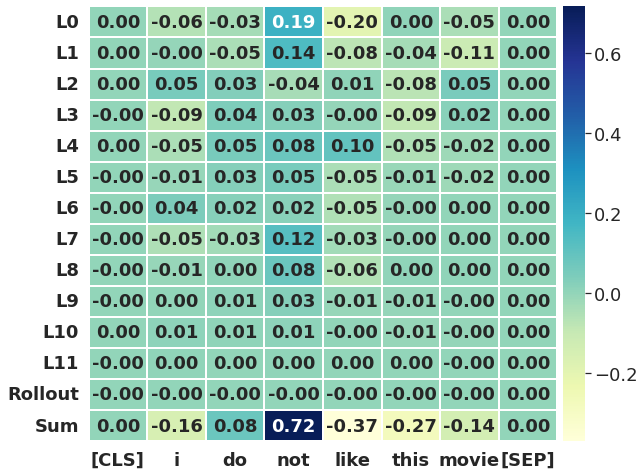

In [182]:
sns.set(font_scale=2)
sns.set(rc = {'figure.figsize':(10,8)})
ax = sns.heatmap(norm1, xticklabels = tokens, yticklabels=yticklabels,cmap="YlGnBu", 
                 linewidths=0.1, annot=True, annot_kws={"fontsize":18, 'fontweight':'heavy'}, cbar_kws={"values":None, "location":'right',
                                                            "pad":0.01}, fmt='.2f', cbar = True)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18, fontweight = 'heavy')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18, fontweight = 'heavy')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

fig = ax.get_figure()
fig.savefig('heatmap.pdf')